In [1]:
import os
import tensorflow as tf
import keras.backend.tensorflow_backend as KTF

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
config = tf.ConfigProto()  
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
KTF.set_session(sess)

Using TensorFlow backend.


# Channnel: F4-EOG (LEFT)

In [3]:
Path={
    'data':"F:/ISRUC-SLEEP_S3_DE.npz",
}

In [4]:
import numpy as np
import time
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
#from SLEEP_Utils import PrintScore,plot_confusion_matrix_ALL

# 读取数据
ReadList = np.load(Path['data'],allow_pickle=True)

Fold_Num    = ReadList['Fold_Num']    #每折样本数 [31]
#All_Data    = ReadList['All_Data']    #所有数据[samples, channels, features]
#All_Label   = ReadList['All_Label']   #one-hot[samples, 5]
#All_Label_n = ReadList['All_Label_n'] #数字[samples,]（0-W, 1-N1, 2-N2, 3-N3, 4-R）

# Out-分31折数据——list-len=31
Out_Data    = ReadList['Fold_Data']
Out_Label   = ReadList['Fold_Label']
#Out_Label_n = ReadList['Out_Label_n']

print("Read data successfully")

Read data successfully


In [5]:
#定义——添加时间上下文
def AddContext(x, context, label=False, dtype=float):
    ret = []
    assert context%2==1, "context value error."
    
    cut = int(context/2)
    if label:
        for p in range(10):
            tData=x[p][cut:x[p].shape[0]-cut]
            ret.append(tData)
            #print(tData.shape)
    else:
        for p in range(10):
            tData=np.zeros([x[p].shape[0]- 2*cut,context,x[p].shape[1],x[p].shape[2]],dtype=dtype)
            for i in range(cut,x[p].shape[0]-cut):
                tData[i-cut]=x[p][i-cut:i+cut+1]
            #print(tData.shape)
            ret.append(tData)
    return ret

In [6]:
context=5
#添加时间上下文
Out_Data    = AddContext(Out_Data,context)
Out_Label   = AddContext(Out_Label,context,label=True)
#Out_Label_n = AddContext(Out_Label_n,context,label=True)
Fold_Num_c  = Fold_Num+1-context

#for i in range(10):
#    if i==0:    All_Label_n_context=Out_Label_n[i]
#    else:       All_Label_n_context=np.concatenate((All_Label_n_context,Out_Label_n[i]))
        
print('Context added successfully.',np.sum(Fold_Num_c))

Context added successfully. 8549


In [7]:
for i in range(10):
    Out_Data[i] = np.reshape(Out_Data[i],(-1,5,90))
    print(i,'ok')

0 ok
1 ok
2 ok
3 ok
4 ok
5 ok
6 ok
7 ok
8 ok
9 ok


In [22]:
from tensorflow import keras
from tensorflow.keras import models,layers

n_Context, n_Feature = 5,90
def build():
    ###############################################################################

    data_layer = layers.Input(shape=(n_Context, n_Feature))
    data_drop = layers.Dropout(0.2)(data_layer)

    MLP_out = layers.Dense(300)(data_drop)
    MLP_out = layers.LeakyReLU()(MLP_out)
    MLP_out = layers.Dropout(0.5)(MLP_out)

    MLP_out = layers.Dense(300)(MLP_out)
    MLP_out = layers.LeakyReLU()(MLP_out)
    MLP_out = layers.Dropout(0.5)(MLP_out)

    LSTM_out = layers.LSTM(300)(MLP_out)

    softmax = layers.Dense(5,activation='softmax')(LSTM_out)

    model = models.Model(inputs = data_layer, outputs = softmax)
    model.compile(
        optimizer=keras.optimizers.SGD(lr=0.005, momentum=0.9),
        loss='categorical_crossentropy',
        metrics=['acc']
    )

    return model

In [24]:
all_scores=[]
for i in range(10):
    print('Fold #', i,end='  ')
    
    #构建数据
    isFirst=True
    for p in range(10):
        if p!=i:
            if isFirst:
                trainX = Out_Data[p]
                trainY = Out_Label[p]
                #trainY_oh = Out_Label_n[p]
                isFirst = False
            else:
                trainX = np.concatenate((trainX, Out_Data[p]))
                trainY = np.concatenate((trainY, Out_Label[p]))
                #trainY_oh = np.concatenate((trainY_oh, Out_Label_n[p]))
        else:
            testX = Out_Data[p]
            testY = Out_Label[p]
        
    #trainX = trainX.reshape(-1,5,26*9)
    #testX = testX.reshape(-1,5,26*9)
    #trainX = trainX[:,:,0,:]
    #testX = testX[:,:,0,:]
    print('  Train:',trainX.shape,'  Test:',testX.shape)
    
    model=build()
    if i==0:
        model.summary()
    #model.fit(trainX,trainY,batch_size=500,epochs=5)
    history = model.fit(
        x = trainX,
        y = trainY,
        epochs = 100,
        batch_size = 500,
        shuffle = True,
        validation_data = (testX, testY),
        verbose=2,
        callbacks=[keras.callbacks.ModelCheckpoint('./test/Best_model_'+str(i)+'.h5', 
                                                   monitor='val_acc', 
                                                   verbose=0, 
                                                   save_best_only=True, 
                                                   save_weights_only=False, 
                                                   mode='auto', 
                                                   period=1 )])
    model.load_weights('./test/Best_model_'+str(i)+'.h5')
    
    val_mse, val_acc = model.evaluate(testX, testY, verbose=0)
    print('Evaluate',val_acc)
    all_scores.append(val_acc)
    
    # Predict
    predicts = model.predict(testX)
    AllPred_temp = np.argmax(predicts, axis=1)
    if i == 0:
        AllTrue = testY
        AllPred = AllPred_temp
    else:
        AllTrue = np.concatenate((AllTrue,testY))
        AllPred = np.concatenate((AllPred,AllPred_temp))
    
    if i==0:
        fit_acc=np.array(history.history['acc'])*Fold_Num[i]
        fit_loss=np.array(history.history['loss'])*Fold_Num[i]
        fit_val_loss=np.array(history.history['val_loss'])*Fold_Num[i]
        fit_val_acc=np.array(history.history['val_acc'])*Fold_Num[i]
    else:
        fit_acc=fit_acc+np.array(history.history['acc'])*Fold_Num[i]
        fit_loss=fit_loss+np.array(history.history['loss'])*Fold_Num[i]
        fit_val_loss=fit_val_loss+np.array(history.history['val_loss'])*Fold_Num[i]
        fit_val_acc=fit_val_acc+np.array(history.history['val_acc'])*Fold_Num[i]
fit_acc      = fit_acc/len(AllPred)
fit_loss     = fit_loss/len(AllPred)
fit_val_loss = fit_val_loss/len(AllPred)
fit_val_acc  = fit_val_acc/len(AllPred)

Fold # 0    Train: (7629, 5, 90)   Test: (920, 5, 90)
Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 5, 90)]           0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 5, 90)             0         
_________________________________________________________________
dense_15 (Dense)             (None, 5, 300)            27300     
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 5, 300)            0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 5, 300)            0         
_________________________________________________________________
dense_16 (Dense)             (None, 5, 300)            90300     
_________________________________________________________________
leaky

7629/7629 - 2s - loss: 0.4914 - acc: 0.8027 - val_loss: 0.4991 - val_acc: 0.8033
Epoch 69/100
7629/7629 - 2s - loss: 0.4977 - acc: 0.8019 - val_loss: 0.4916 - val_acc: 0.8098
Epoch 70/100
7629/7629 - 2s - loss: 0.5039 - acc: 0.8004 - val_loss: 0.4899 - val_acc: 0.8098
Epoch 71/100
7629/7629 - 2s - loss: 0.4987 - acc: 0.8008 - val_loss: 0.4877 - val_acc: 0.8109
Epoch 72/100
7629/7629 - 2s - loss: 0.4927 - acc: 0.7993 - val_loss: 0.4891 - val_acc: 0.8087
Epoch 73/100
7629/7629 - 2s - loss: 0.4956 - acc: 0.7998 - val_loss: 0.4914 - val_acc: 0.8087
Epoch 74/100
7629/7629 - 2s - loss: 0.4893 - acc: 0.8043 - val_loss: 0.4891 - val_acc: 0.8098
Epoch 75/100
7629/7629 - 2s - loss: 0.4939 - acc: 0.7994 - val_loss: 0.4844 - val_acc: 0.8130
Epoch 76/100
7629/7629 - 2s - loss: 0.4956 - acc: 0.8012 - val_loss: 0.4892 - val_acc: 0.8065
Epoch 77/100
7629/7629 - 2s - loss: 0.4897 - acc: 0.8001 - val_loss: 0.4889 - val_acc: 0.8054
Epoch 78/100
7629/7629 - 2s - loss: 0.4883 - acc: 0.8039 - val_loss: 0.48

Epoch 53/100
7642/7642 - 2s - loss: 0.5019 - acc: 0.7981 - val_loss: 0.7535 - val_acc: 0.7067
Epoch 54/100
7642/7642 - 2s - loss: 0.4989 - acc: 0.8012 - val_loss: 0.7637 - val_acc: 0.7023
Epoch 55/100
7642/7642 - 2s - loss: 0.4972 - acc: 0.8021 - val_loss: 0.7592 - val_acc: 0.7023
Epoch 56/100
7642/7642 - 2s - loss: 0.4991 - acc: 0.7991 - val_loss: 0.7604 - val_acc: 0.6957
Epoch 57/100
7642/7642 - 2s - loss: 0.4943 - acc: 0.8083 - val_loss: 0.7650 - val_acc: 0.7001
Epoch 58/100
7642/7642 - 2s - loss: 0.4943 - acc: 0.8035 - val_loss: 0.7709 - val_acc: 0.6924
Epoch 59/100
7642/7642 - 2s - loss: 0.4945 - acc: 0.7994 - val_loss: 0.7633 - val_acc: 0.6990
Epoch 60/100
7642/7642 - 2s - loss: 0.4881 - acc: 0.8042 - val_loss: 0.7617 - val_acc: 0.7001
Epoch 61/100
7642/7642 - 2s - loss: 0.4882 - acc: 0.8069 - val_loss: 0.7719 - val_acc: 0.6968
Epoch 62/100
7642/7642 - 2s - loss: 0.4878 - acc: 0.8040 - val_loss: 0.7513 - val_acc: 0.7067
Epoch 63/100
7642/7642 - 2s - loss: 0.4877 - acc: 0.8067 - v

Epoch 38/100
7759/7759 - 2s - loss: 0.5392 - acc: 0.7858 - val_loss: 0.5824 - val_acc: 0.7722
Epoch 39/100
7759/7759 - 2s - loss: 0.5255 - acc: 0.7894 - val_loss: 0.5861 - val_acc: 0.7734
Epoch 40/100
7759/7759 - 2s - loss: 0.5245 - acc: 0.7935 - val_loss: 0.5867 - val_acc: 0.7709
Epoch 41/100
7759/7759 - 2s - loss: 0.5252 - acc: 0.7919 - val_loss: 0.5966 - val_acc: 0.7722
Epoch 42/100
7759/7759 - 2s - loss: 0.5246 - acc: 0.7911 - val_loss: 0.5924 - val_acc: 0.7747
Epoch 43/100
7759/7759 - 2s - loss: 0.5248 - acc: 0.7915 - val_loss: 0.5881 - val_acc: 0.7734
Epoch 44/100
7759/7759 - 2s - loss: 0.5220 - acc: 0.7920 - val_loss: 0.5945 - val_acc: 0.7709
Epoch 45/100
7759/7759 - 2s - loss: 0.5218 - acc: 0.7926 - val_loss: 0.5828 - val_acc: 0.7709
Epoch 46/100
7759/7759 - 2s - loss: 0.5205 - acc: 0.7947 - val_loss: 0.5831 - val_acc: 0.7722
Epoch 47/100
7759/7759 - 2s - loss: 0.5207 - acc: 0.7908 - val_loss: 0.5815 - val_acc: 0.7747
Epoch 48/100
7759/7759 - 2s - loss: 0.5163 - acc: 0.7966 - v

Epoch 23/100
7789/7789 - 2s - loss: 0.5474 - acc: 0.7829 - val_loss: 1.2540 - val_acc: 0.5434
Epoch 24/100
7789/7789 - 2s - loss: 0.5521 - acc: 0.7793 - val_loss: 1.2758 - val_acc: 0.5368
Epoch 25/100
7789/7789 - 2s - loss: 0.5476 - acc: 0.7846 - val_loss: 1.2534 - val_acc: 0.5421
Epoch 26/100
7789/7789 - 2s - loss: 0.5441 - acc: 0.7772 - val_loss: 1.2625 - val_acc: 0.5434
Epoch 27/100
7789/7789 - 2s - loss: 0.5449 - acc: 0.7844 - val_loss: 1.2886 - val_acc: 0.5395
Epoch 28/100
7789/7789 - 2s - loss: 0.5423 - acc: 0.7821 - val_loss: 1.2644 - val_acc: 0.5434
Epoch 29/100
7789/7789 - 2s - loss: 0.5405 - acc: 0.7866 - val_loss: 1.2896 - val_acc: 0.5395
Epoch 30/100
7789/7789 - 2s - loss: 0.5350 - acc: 0.7864 - val_loss: 1.2853 - val_acc: 0.5434
Epoch 31/100
7789/7789 - 2s - loss: 0.5349 - acc: 0.7834 - val_loss: 1.2754 - val_acc: 0.5461
Epoch 32/100
7789/7789 - 2s - loss: 0.5236 - acc: 0.7941 - val_loss: 1.2782 - val_acc: 0.5447
Epoch 33/100
7789/7789 - 2s - loss: 0.5244 - acc: 0.7882 - v

Epoch 8/100
7639/7639 - 3s - loss: 0.7139 - acc: 0.7199 - val_loss: 0.6932 - val_acc: 0.7473
Epoch 9/100
7639/7639 - 3s - loss: 0.6913 - acc: 0.7297 - val_loss: 0.6802 - val_acc: 0.7495
Epoch 10/100
7639/7639 - 3s - loss: 0.6729 - acc: 0.7353 - val_loss: 0.6715 - val_acc: 0.7560
Epoch 11/100
7639/7639 - 3s - loss: 0.6586 - acc: 0.7375 - val_loss: 0.6554 - val_acc: 0.7659
Epoch 12/100
7639/7639 - 3s - loss: 0.6470 - acc: 0.7408 - val_loss: 0.6521 - val_acc: 0.7637
Epoch 13/100
7639/7639 - 3s - loss: 0.6352 - acc: 0.7488 - val_loss: 0.6292 - val_acc: 0.7736
Epoch 14/100
7639/7639 - 3s - loss: 0.6203 - acc: 0.7518 - val_loss: 0.6354 - val_acc: 0.7736
Epoch 15/100
7639/7639 - 3s - loss: 0.6150 - acc: 0.7547 - val_loss: 0.6297 - val_acc: 0.7692
Epoch 16/100
7639/7639 - 3s - loss: 0.6117 - acc: 0.7552 - val_loss: 0.6082 - val_acc: 0.7736
Epoch 17/100
7639/7639 - 3s - loss: 0.6055 - acc: 0.7587 - val_loss: 0.6115 - val_acc: 0.7714
Epoch 18/100
7639/7639 - 3s - loss: 0.6021 - acc: 0.7619 - val

Epoch 96/100
7639/7639 - 3s - loss: 0.4832 - acc: 0.8052 - val_loss: 0.5454 - val_acc: 0.7989
Epoch 97/100
7639/7639 - 3s - loss: 0.4778 - acc: 0.8061 - val_loss: 0.5370 - val_acc: 0.8022
Epoch 98/100
7639/7639 - 3s - loss: 0.4798 - acc: 0.8069 - val_loss: 0.5417 - val_acc: 0.7989
Epoch 99/100
7639/7639 - 3s - loss: 0.4744 - acc: 0.8118 - val_loss: 0.5428 - val_acc: 0.7945
Epoch 100/100
7639/7639 - 3s - loss: 0.4766 - acc: 0.8060 - val_loss: 0.5456 - val_acc: 0.7956
Evaluate 0.8021978
Fold # 5    Train: (7730, 5, 90)   Test: (819, 5, 90)
Train on 7730 samples, validate on 819 samples
Epoch 1/100
7730/7730 - 5s - loss: 1.4772 - acc: 0.3968 - val_loss: 1.2464 - val_acc: 0.4371
Epoch 2/100
7730/7730 - 3s - loss: 1.1332 - acc: 0.5801 - val_loss: 1.0490 - val_acc: 0.5336
Epoch 3/100
7730/7730 - 3s - loss: 0.9510 - acc: 0.6464 - val_loss: 0.9528 - val_acc: 0.5836
Epoch 4/100
7730/7730 - 3s - loss: 0.8551 - acc: 0.6819 - val_loss: 0.8998 - val_acc: 0.6276
Epoch 5/100
7730/7730 - 3s - loss: 0.

Epoch 81/100
7730/7730 - 3s - loss: 0.4803 - acc: 0.8069 - val_loss: 0.6418 - val_acc: 0.7265
Epoch 82/100
7730/7730 - 3s - loss: 0.4787 - acc: 0.8116 - val_loss: 0.6658 - val_acc: 0.7192
Epoch 83/100
7730/7730 - 3s - loss: 0.4726 - acc: 0.8136 - val_loss: 0.6465 - val_acc: 0.7253
Epoch 84/100
7730/7730 - 3s - loss: 0.4744 - acc: 0.8100 - val_loss: 0.6522 - val_acc: 0.7277
Epoch 85/100
7730/7730 - 3s - loss: 0.4757 - acc: 0.8151 - val_loss: 0.6693 - val_acc: 0.7253
Epoch 86/100
7730/7730 - 3s - loss: 0.4699 - acc: 0.8101 - val_loss: 0.6454 - val_acc: 0.7289
Epoch 87/100
7730/7730 - 3s - loss: 0.4735 - acc: 0.8092 - val_loss: 0.6681 - val_acc: 0.7253
Epoch 88/100
7730/7730 - 3s - loss: 0.4756 - acc: 0.8140 - val_loss: 0.6525 - val_acc: 0.7253
Epoch 89/100
7730/7730 - 3s - loss: 0.4686 - acc: 0.8133 - val_loss: 0.6400 - val_acc: 0.7253
Epoch 90/100
7730/7730 - 3s - loss: 0.4734 - acc: 0.8133 - val_loss: 0.6399 - val_acc: 0.7265
Epoch 91/100
7730/7730 - 3s - loss: 0.4692 - acc: 0.8146 - v

Epoch 66/100
7769/7769 - 3s - loss: 0.4870 - acc: 0.8044 - val_loss: 0.8377 - val_acc: 0.7333
Epoch 67/100
7769/7769 - 3s - loss: 0.4899 - acc: 0.8059 - val_loss: 0.8476 - val_acc: 0.7333
Epoch 68/100
7769/7769 - 3s - loss: 0.4877 - acc: 0.8059 - val_loss: 0.8445 - val_acc: 0.7321
Epoch 69/100
7769/7769 - 3s - loss: 0.4916 - acc: 0.8069 - val_loss: 0.8435 - val_acc: 0.7333
Epoch 70/100
7769/7769 - 3s - loss: 0.4934 - acc: 0.8032 - val_loss: 0.8423 - val_acc: 0.7333
Epoch 71/100
7769/7769 - 3s - loss: 0.4822 - acc: 0.8098 - val_loss: 0.8448 - val_acc: 0.7333
Epoch 72/100
7769/7769 - 3s - loss: 0.4893 - acc: 0.8046 - val_loss: 0.8411 - val_acc: 0.7333
Epoch 73/100
7769/7769 - 3s - loss: 0.4929 - acc: 0.8059 - val_loss: 0.8394 - val_acc: 0.7333
Epoch 74/100
7769/7769 - 3s - loss: 0.4813 - acc: 0.8125 - val_loss: 0.8368 - val_acc: 0.7333
Epoch 75/100
7769/7769 - 3s - loss: 0.4856 - acc: 0.8018 - val_loss: 0.8379 - val_acc: 0.7333
Epoch 76/100
7769/7769 - 3s - loss: 0.4868 - acc: 0.8041 - v

Epoch 51/100
7583/7583 - 3s - loss: 0.5384 - acc: 0.7821 - val_loss: 0.3655 - val_acc: 0.8468
Epoch 52/100
7583/7583 - 3s - loss: 0.5392 - acc: 0.7835 - val_loss: 0.3718 - val_acc: 0.8437
Epoch 53/100
7583/7583 - 3s - loss: 0.5379 - acc: 0.7825 - val_loss: 0.3632 - val_acc: 0.8499
Epoch 54/100
7583/7583 - 3s - loss: 0.5295 - acc: 0.7891 - val_loss: 0.3644 - val_acc: 0.8499
Epoch 55/100
7583/7583 - 4s - loss: 0.5324 - acc: 0.7854 - val_loss: 0.3648 - val_acc: 0.8499
Epoch 56/100
7583/7583 - 4s - loss: 0.5364 - acc: 0.7843 - val_loss: 0.3768 - val_acc: 0.8447
Epoch 57/100
7583/7583 - 3s - loss: 0.5367 - acc: 0.7866 - val_loss: 0.3799 - val_acc: 0.8437
Epoch 58/100
7583/7583 - 3s - loss: 0.5304 - acc: 0.7872 - val_loss: 0.3682 - val_acc: 0.8509
Epoch 59/100
7583/7583 - 3s - loss: 0.5284 - acc: 0.7873 - val_loss: 0.3723 - val_acc: 0.8478
Epoch 60/100
7583/7583 - 3s - loss: 0.5282 - acc: 0.7872 - val_loss: 0.3705 - val_acc: 0.8509
Epoch 61/100
7583/7583 - 3s - loss: 0.5272 - acc: 0.7883 - v

Epoch 36/100
7614/7614 - 4s - loss: 0.5263 - acc: 0.7938 - val_loss: 0.8759 - val_acc: 0.6652
Epoch 37/100
7614/7614 - 4s - loss: 0.5241 - acc: 0.7917 - val_loss: 0.8602 - val_acc: 0.6631
Epoch 38/100
7614/7614 - 4s - loss: 0.5202 - acc: 0.7937 - val_loss: 0.8598 - val_acc: 0.6663
Epoch 39/100
7614/7614 - 4s - loss: 0.5190 - acc: 0.7967 - val_loss: 0.8543 - val_acc: 0.6695
Epoch 40/100
7614/7614 - 4s - loss: 0.5203 - acc: 0.7943 - val_loss: 0.8555 - val_acc: 0.6652
Epoch 41/100
7614/7614 - 4s - loss: 0.5188 - acc: 0.7947 - val_loss: 0.8509 - val_acc: 0.6684
Epoch 42/100
7614/7614 - 4s - loss: 0.5198 - acc: 0.7943 - val_loss: 0.8470 - val_acc: 0.6706
Epoch 43/100
7614/7614 - 4s - loss: 0.5112 - acc: 0.7933 - val_loss: 0.8504 - val_acc: 0.6663
Epoch 44/100
7614/7614 - 4s - loss: 0.5084 - acc: 0.8018 - val_loss: 0.8333 - val_acc: 0.6706
Epoch 45/100
7614/7614 - 4s - loss: 0.5077 - acc: 0.7963 - val_loss: 0.8560 - val_acc: 0.6674
Epoch 46/100
7614/7614 - 4s - loss: 0.4987 - acc: 0.8035 - v

Epoch 21/100
7787/7787 - 4s - loss: 0.5724 - acc: 0.7754 - val_loss: 0.7926 - val_acc: 0.6575
Epoch 22/100
7787/7787 - 4s - loss: 0.5658 - acc: 0.7744 - val_loss: 0.7802 - val_acc: 0.6601
Epoch 23/100
7787/7787 - 4s - loss: 0.5597 - acc: 0.7809 - val_loss: 0.7932 - val_acc: 0.6588
Epoch 24/100
7787/7787 - 4s - loss: 0.5530 - acc: 0.7825 - val_loss: 0.7907 - val_acc: 0.6535
Epoch 25/100
7787/7787 - 4s - loss: 0.5554 - acc: 0.7840 - val_loss: 0.7815 - val_acc: 0.6627
Epoch 26/100
7787/7787 - 4s - loss: 0.5477 - acc: 0.7831 - val_loss: 0.7936 - val_acc: 0.6614
Epoch 27/100
7787/7787 - 4s - loss: 0.5455 - acc: 0.7834 - val_loss: 0.7949 - val_acc: 0.6588
Epoch 28/100
7787/7787 - 4s - loss: 0.5392 - acc: 0.7871 - val_loss: 0.7824 - val_acc: 0.6680
Epoch 29/100
7787/7787 - 4s - loss: 0.5376 - acc: 0.7853 - val_loss: 0.7937 - val_acc: 0.6549
Epoch 30/100
7787/7787 - 4s - loss: 0.5345 - acc: 0.7884 - val_loss: 0.7891 - val_acc: 0.6627
Epoch 31/100
7787/7787 - 4s - loss: 0.5353 - acc: 0.7904 - v

In [25]:
AllTrue=np.argmax(AllTrue,axis=1)
AllTrue.shape,AllPred.shape

((8549,), (8549,))

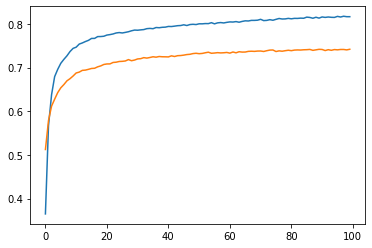

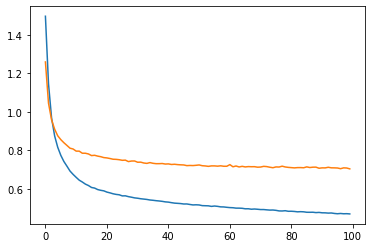

In [26]:
plt.plot(fit_acc)
plt.plot(fit_val_acc)
plt.show()
plt.plot(fit_loss)
plt.plot(fit_val_loss)

In [27]:
def PrintScore(true,pred,savePath=None,average='macro'):
    if savePath == None:
        saveFile = None
    else:
        saveFile=open(savePath+"Result.txt",'a+')
    # Main scores
    F1=metrics.f1_score(true,pred,average=None)
    print("Main scores:")
    print('Acc\tF1S\tKappa\tF1_W\tF1_N1\tF1_N2\tF1_N3\tF1_R',file=saveFile)
    print('%.4f\t%.4f\t%.4f\t%.4f\t%.4f\t%.4f\t%.4f\t%.4f'% (metrics.accuracy_score(true,pred),
                                                             metrics.f1_score(true,pred,average=average),
                                                             metrics.cohen_kappa_score(true,pred),
                                                             F1[0],F1[1],F1[2],F1[3],F1[4]),
                                                             file=saveFile)
    # Classification report
    print("\nClassification report:",file=saveFile)
    print(metrics.classification_report(true,pred,target_names=['Wake','N1','N2','N3','REM']),file=saveFile)
    # Confusion matrix
    print('Confusion matrix:',file=saveFile)
    print(metrics.confusion_matrix(true,pred),file=saveFile)
    # Overall scores
    print('\n    Accuracy\t',metrics.accuracy_score(true,pred),file=saveFile)
    print(' Cohen Kappa\t',metrics.cohen_kappa_score(true,pred),file=saveFile)
    print('    F1-Score\t',metrics.f1_score(true,pred,average=average),'\tAverage =',average,file=saveFile)    
    print('   Precision\t',metrics.precision_score(true,pred,average=average),'\tAverage =',average,file=saveFile)
    print('      Recall\t',metrics.recall_score(true,pred,average=average),'\tAverage =',average,file=saveFile)
    # Results of each class
    print('\nResults of each class:',file=saveFile)
    print('    F1-Score\t',metrics.f1_score(true,pred,average=None),file=saveFile)
    print('   Precision\t',metrics.precision_score(true,pred,average=None),file=saveFile)
    print('      Recall\t',metrics.recall_score(true,pred,average=None),file=saveFile)
    if savePath != None:
        saveFile.close()
    return

In [28]:
PrintScore(AllTrue, AllPred)

Main scores:
Acc	F1S	Kappa	F1_W	F1_N1	F1_N2	F1_N3	F1_R
0.7487	0.7277	0.6771	0.8043	0.4614	0.7210	0.8432	0.8083

Classification report:
              precision    recall  f1-score   support

        Wake       0.76      0.85      0.80      1651
          N1       0.56      0.39      0.46      1215
          N2       0.75      0.70      0.72      2609
          N3       0.80      0.90      0.84      2014
         REM       0.78      0.84      0.81      1060

    accuracy                           0.75      8549
   macro avg       0.73      0.74      0.73      8549
weighted avg       0.74      0.75      0.74      8549

Confusion matrix:
[[1410  146   67   15   13]
 [ 270  475  304    9  157]
 [ 100  170 1817  437   85]
 [   9    1  197 1807    0]
 [  66   52   46    4  892]]

    Accuracy	 0.7487425429874839
 Cohen Kappa	 0.6770627992300613
    F1-Score	 0.7276607513299884 	Average = macro
   Precision	 0.7286696961089005 	Average = macro
      Recall	 0.7360277355087256 	Average = macro
